In [1]:
import os
import sys
import random
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas
import itertools
import tensorflow as tf
import utils

In [2]:
strategy = tf.distribute.OneDeviceStrategy("gpu:0")
# strategy = tf.distribute.OneDeviceStrategy("cpu")

### Settings

In [3]:
data_path = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/calo_matched/*.proto",
             "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/calo_matched/*.proto",
             "ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v2/training/no_calo_matched/*.proto",
             "gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
            }
                 

In [4]:
models_path = "/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/seeding/"

#rain_steps_per_epoch = 
#eval_steps_per_epoch = 3e5 // batch_size
from collections import namedtuple
Args = namedtuple('args', [ 'models_path', 'load','nepochs','ntrain','nval',
                            'batch_size','lr_decay','lr', 'hidden_dim',
                            'n_layers', 'opt'])

args = Args( 
models_path = models_path,
load = False,
nepochs = 50,
ntrain = 300000,
nval = 20000,
lr_decay = 0 ,
lr = 1e-3,
batch_size = 512,
n_layers = 4,
hidden_dim = 64,
opt='nadam'
        )

### Dataset loading

In [5]:
seed_feat_means = np.load('seed_features_means.npy')
seed_feat_stds = np.load('seed_features_stds.npy')

In [6]:
def prepare_element(seed,cls):
    norm_feat = (seed['s_f'] - seed_feat_means) / seed_feat_stds
    X = tf.gather(seed['s_f'], indices=[0,1,4,6,16,17,18,19,20,21,22,23])
    X_scaled = tf.gather(norm_feat, indices=[0,1,4,6,16,17,18,19,20,21,22,23])
    calomatch = seed['s_l'][0]
    caloseed = seed['s_l'][1]
    seed_pos = tf.cast(tf.where(cls['cl_l'][:,0]==1)[0], tf.float32)
    n_cl = [tf.cast(seed['n_cl'], tf.float32)]
    X_train = tf.concat([X_scaled, seed_pos, n_cl], axis=0)
    X = tf.concat([X, seed_pos, n_cl], axis=0)
    return X_train,X, calomatch, caloseed, seed['f']

def only_training(X_train,X, calomatch, caloseed, flavour):
    return X_train, caloseed

def filter_seed(X_train,X,calomatch, caloseed,flavour):
    if X[3] < 40: return True
    return False


In [14]:
datasets = {}
for n, p in data_path.items():
    datasets[n] = utils.load_dataset(p, options={'read_hits':False})\
                    .map(prepare_element,deterministic=False,num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                    .filter(filter_seed)\
                    .map(only_training)
    
total_ds = tf.data.experimental.sample_from_datasets(list(datasets.values()), weights=[0.5]*len(datasets))
total_ds = total_ds.shuffle(10000, reshuffle_each_iteration=True)

    
ds_train = total_ds.take(args.ntrain).batch(args.batch_size).prefetch(100).repeat(args.nepochs)
ds_test = total_ds.skip(args.ntrain).take(args.nval).batch(args.batch_size).prefetch(100).repeat(args.nepochs)


In [8]:
idata = iter(ds_train)
d = next(idata)

In [9]:
d

(<tf.Tensor: shape=(512, 14), dtype=float32, numpy=
 array([[ 1.0967913e+00,  5.0225937e-01,  1.5260020e+00, ...,
         -3.3301032e-01,  1.0000000e+00,  9.0000000e+00],
        [-4.1505182e-01,  1.1453192e-01,  9.8926136e-03, ...,
         -1.0838136e-02,  2.0000000e+00,  1.2000000e+01],
        [-1.0298051e+00,  1.0356655e+00, -1.5062168e+00, ...,
          6.4013976e-01,  0.0000000e+00,  5.0000000e+00],
        ...,
        [-1.0423607e+00, -8.9673504e-02, -1.5062168e+00, ...,
          1.6054479e-02,  1.0000000e+00,  1.0000000e+01],
        [-8.1782669e-01, -1.5785578e+00,  9.8926136e-03, ...,
         -2.9804217e-02,  1.0000000e+00,  6.0000000e+00],
        [-1.0957309e+00, -3.0746642e-01, -1.5062168e+00, ...,
          4.5471150e-02,  1.0000000e+00,  6.0000000e+00]], dtype=float32)>,
 <tf.Tensor: shape=(512,), dtype=int64, numpy=
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
  

In [14]:
def get_unique_run():
    previous_runs = os.listdir(args.models_path)
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1
    return run_number

In [15]:
if args.lr_decay > 0:
        #lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        #    args.lr,
        #    decay_steps=int(args.ntrain//args.batch_size),
        #    decay_rate=args.lr_decay
        #)
        lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
            args.lr,
            decay_steps=int(args.ntrain//args.batch_size),
            decay_rate=args.lr_decay
        )
else:
    lr_schedule = args.lr


In [16]:
if not os.path.isdir(args.models_path):
    os.makedirs(args.models_path)

name =  'run_{:02}'.format(get_unique_run())

outdir = args.models_path + name

if os.path.isdir(outdir):
    print("Output directory exists: {}".format(outdir), file=sys.stderr)
else:
    os.makedirs(outdir)
    
    
print(outdir)

/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/seeding/run_09


In [17]:
callbacks = []
# tb = tf.keras.callbacks.TensorBoard(
#     log_dir=outdir, histogram_freq=2, 
#     write_graph=False, 
#     write_images=True,
#     update_freq='epoch',
#     profile_batch=0,
# )
# tb.set_model(model)
# callbacks += [tb]


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=outdir + "/weights.{epoch:02d}-{val_loss:.6f}.hdf5",
    monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch',
    options=None
)
callbacks += [cp_callback]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=6, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False

)
callbacks += [early_stopping]


In [18]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [19]:
from tensorflow.keras import layers, activations, metrics 

with strategy.scope():
    # Define Sequential model with 3 layers
    model = tf.keras.Sequential()
    for nl in range(args.n_layers):
        model.add(layers.Dense(args.hidden_dim, name="layer"+str(nl)))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
    model.add(layers.Dense(1, activation="sigmoid", name="Out"))
    # Call model on a test input
    y = model(d[0])
    
    
    metrics =[
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision', thresholds=[0.5]),
      metrics.Recall(name='recall',thresholds=[0.5]),
      metrics.AUC(name='auc')
    ]

    
    model.compile(optimizer=args.opt, loss='binary_crossentropy',
        metrics=metrics)
    
    model.summary()
    
    if args.nepochs > 0:
        ret = model.fit(ds_train,
            validation_data=ds_test, epochs=args.nepochs,
            steps_per_epoch=args.ntrain//args.batch_size, validation_steps=args.nval//args.batch_size,
            verbose=True,
            callbacks=callbacks
        )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (Dense)               (512, 64)                 960       
_________________________________________________________________
batch_normalization (BatchNo (512, 64)                 256       
_________________________________________________________________
re_lu (ReLU)                 (512, 64)                 0         
_________________________________________________________________
layer1 (Dense)               (512, 64)                 4160      
_________________________________________________________________
batch_normalization_1 (Batch (512, 64)                 256       
_________________________________________________________________
re_lu_1 (ReLU)               (512, 64)                 0         
_________________________________________________________________
layer2 (Dense)               (512, 64)                 4

Epoch 14/50
585/585 [==============================] - ETA: 0s - loss: 0.1117 - accuracy: 0.9647 - precision: 0.9632 - recall: 0.9014 - auc: 0.9826
Epoch 00014: val_loss did not improve from 0.10904
585/585 [==============================] - 186s 318ms/step - loss: 0.1117 - accuracy: 0.9647 - precision: 0.9632 - recall: 0.9014 - auc: 0.9826 - val_loss: 0.1137 - val_accuracy: 0.9647 - val_precision: 0.9592 - val_recall: 0.9073 - val_auc: 0.9810
Epoch 00014: early stopping


In [20]:
model.save(outdir + '/model')

In [21]:
def plot_loss(history, label):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
              label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
              label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')


In [22]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.9,1])
    else:
      plt.ylim([0.8,1])

    plt.legend()


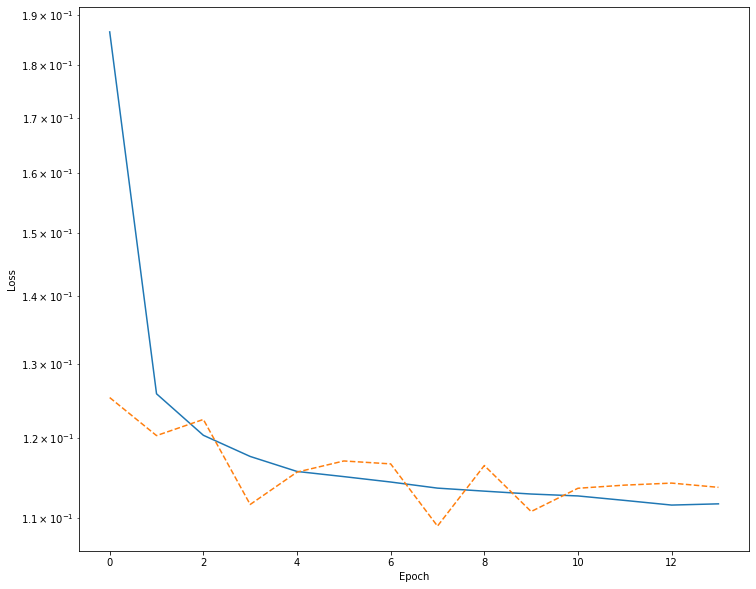

In [23]:
plot_loss(ret, "loss")

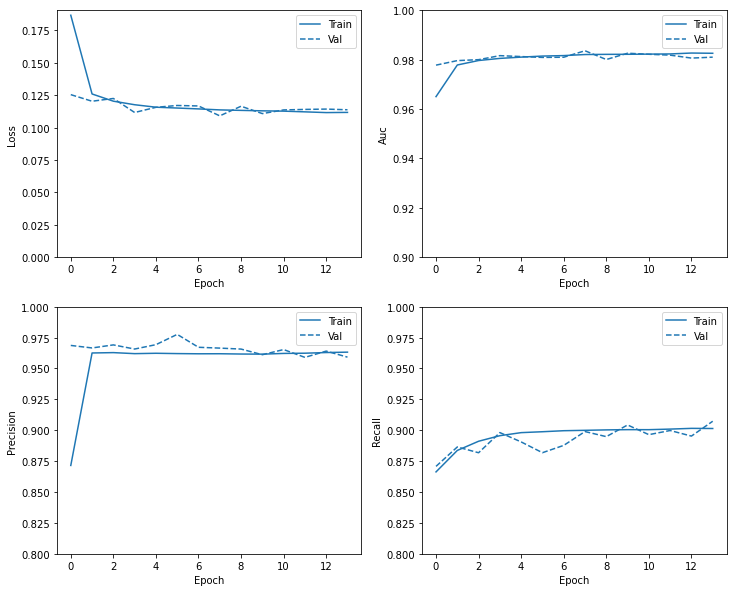

In [24]:
plot_metrics(ret)

In [25]:
with open(outdir + "/args.txt",'w') as config:
    config.write(str(args))
    

# Evaluation

In [7]:
outdir = '/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/seeding/run_09/'

In [8]:
model = tf.keras.models.load_model("/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/seeding/run_09/model")

In [12]:
datasets_val = {}
for n, p in data_path.items():
    datasets_val[n] = utils.load_dataset(p, options={'read_hits':False})\
                    .map(prepare_element,deterministic=False,num_parallel_calls=tf.data.experimental.AUTOTUNE).filter(filter_seed)\
                    .filter(filter_seed)
    
total_ds = tf.data.experimental.sample_from_datasets(list(datasets_val.values()), weights=[0.5]*len(datasets_val))
#total_ds = total_ds.shuffle(10000, reshuffle_each_iteration=True)

ds_val = total_ds.skip(args.ntrain + args.nval).take(300000).batch(512)

In [13]:
it = iter(ds_val)
next(it)

(<tf.Tensor: shape=(512, 14), dtype=float32, numpy=
 array([[ 7.2489130e-01, -4.4083226e-01,  9.8926136e-03, ...,
          6.7995954e-01,  1.0000000e+00,  2.2000000e+01],
        [ 1.4791740e+00, -1.8817419e-01,  1.5260020e+00, ...,
          1.7106999e+00,  1.0000000e+00,  6.0000000e+00],
        [-4.2686102e-01,  6.1575647e-02,  9.8926136e-03, ...,
         -2.1799749e-01,  0.0000000e+00,  8.0000000e+00],
        ...,
        [ 1.7758198e+00,  2.3251107e-01,  1.5260020e+00, ...,
          2.8059025e+00,  0.0000000e+00,  2.0000000e+00],
        [-6.1725998e-01, -1.6001597e-01,  9.8926136e-03, ...,
         -2.8142190e-01,  1.0000000e+00,  1.1000000e+01],
        [ 1.0638072e+00, -6.6323131e-01,  1.5260020e+00, ...,
          3.8063145e-01,  0.0000000e+00,  3.0000000e+00]], dtype=float32)>,
 <tf.Tensor: shape=(512, 14), dtype=float32, numpy=
 array([[ 1.1544467e+00, -8.0798954e-01,  0.0000000e+00, ...,
          1.7102441e-02,  1.0000000e+00,  2.2000000e+01],
        [ 2.3712418e+00, 

In [14]:
cols = ["seed_eta","seed_phi", "seed_iz", 
        "et_seed","seed_r9","seed_sigmaIetaIeta", "seed_sigmaIetaIphi",
        "seed_sigmaIphiIphi","seed_swissCross",
        "seed_nxtals","seed_etaWidth","seed_phiWidth", "seed_pos","n_cl"
        ]

from collections import defaultdict
result = defaultdict(list)

for ib, (X_train,X, calomatch, caloseed, flavour) in enumerate(ds_val):
    if ib % 5 == 0: print(".",end="")
        
    ypred = model(X_train)
    #print(ypred)
    
    for yt,yp,ym,fl in zip(caloseed, ypred,calomatch, flavour):
        result['y'].append(yp.numpy()[0])
        result['y_true'].append(yt.numpy())
        result['calo_match'].append(ym.numpy())
        result['fl'].append(fl.numpy())
   
    for ix in range(X.shape[0]):
        for ic, col in enumerate(cols):
            result[col].append(X.numpy()[ix,ic])
                
    #if ib>4: break

......................................................................................................................

In [15]:
import pandas as pd
df = pd.DataFrame(result)
df.to_csv(outdir+"/evaluation.csv",index=False,sep=";")

In [4]:
import pandas as pd
df = pd.read_csv(outdir+"/evaluation.csv",sep=";")

In [16]:
from collections import defaultdict
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#mport mplhep as hep
#lt.style.use(hep.style.CMS)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (5,4)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
# Overall - both left and right annotation

In [17]:
df.head()

,y,y_true,calo_match,fl,seed_eta,seed_phi,seed_iz,et_seed,seed_r9,seed_sigmaIetaIeta,seed_sigmaIetaIphi,seed_sigmaIphiIphi,seed_swissCross,seed_nxtals,seed_etaWidth,seed_phiWidth,seed_pos,n_cl
0,0.014488,0,0,22,2.097216,-2.277913,1.0,0.846561,1.000000,0.000000,0.000000,0.000427,1.000000,1.0,0.001965,0.000085,0.0,3.0
1,0.015048,0,0,22,2.392957,0.891762,1.0,0.832935,1.000000,0.000000,0.000000,0.000000,1.000000,1.0,0.002267,0.000095,0.0,2.0
2,0.006114,0,0,22,0.301643,-2.474374,0.0,0.869016,1.000000,0.008997,0.000081,0.008997,1.000000,1.0,0.009264,0.008069,1.0,9.0
3,0.035250,1,1,22,-2.171462,-2.467291,-1.0,1.289315,0.806955,0.023150,-0.000281,0.028738,0.260884,1.0,0.019861,0.024855,0.0,5.0
4,0.011334,0,0,22,1.174598,2.453802,0.0,0.850378,1.000000,0.008736,0.000000,0.000000,0.135150,2.0,0.008715,0.001249,0.0,8.0


(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

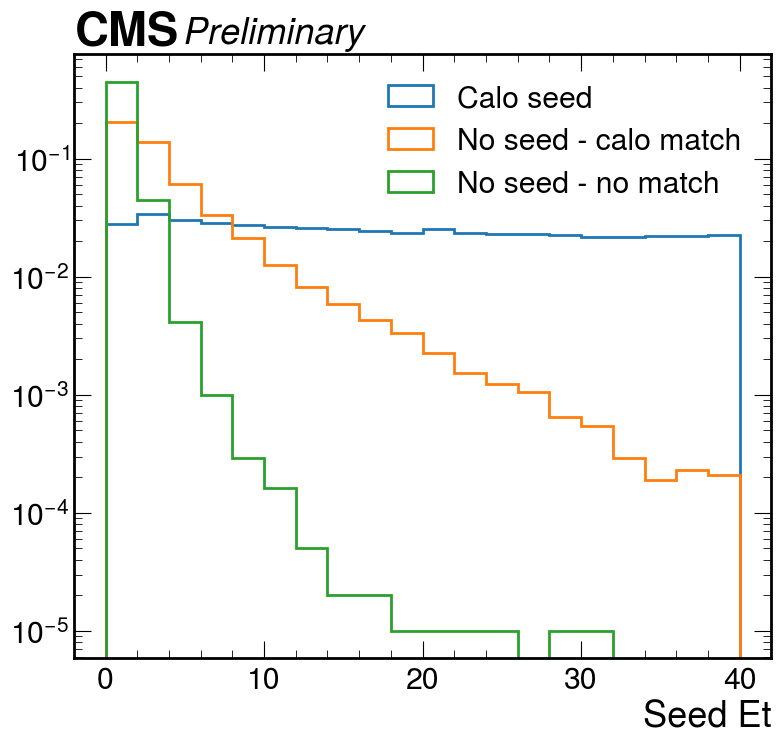

In [24]:
bins = 20
xrange = [0,40]
var = 'et_seed'
title = 'Seed Et'
log = True

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
plt.legend()
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary '))

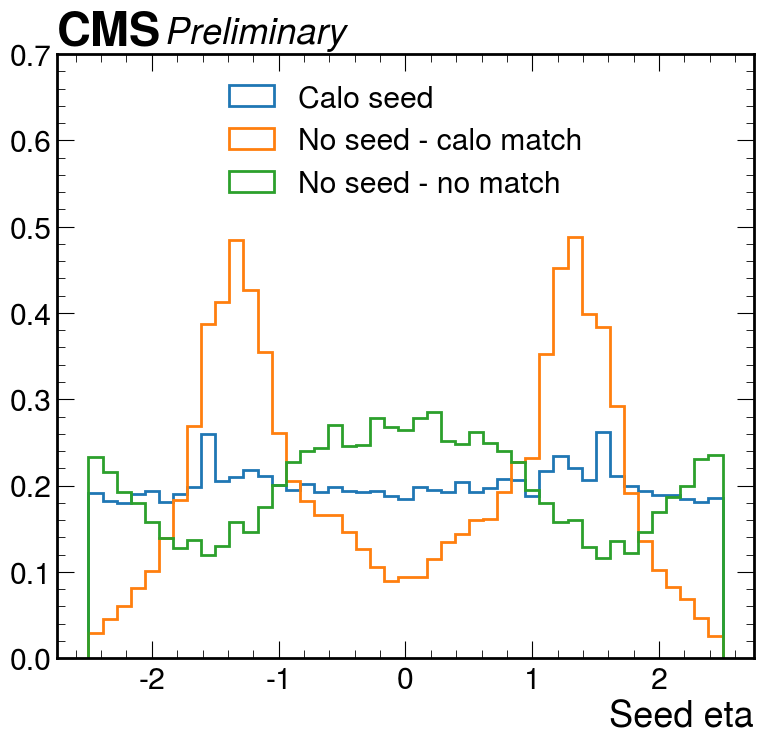

In [19]:
bins = 45
xrange = [-2.5,2.5]
var = 'seed_eta'
title = 'Seed eta'
log = False
ylim = [0, 0.7]


fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend(loc="upper center")
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

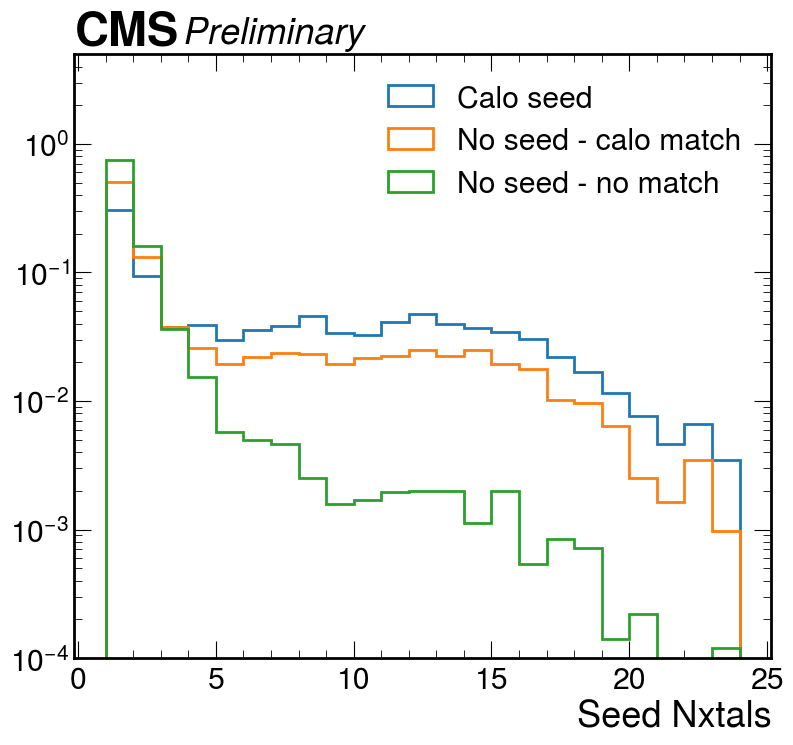

In [27]:
bins = 23
xrange = [1,24]
var = 'seed_nxtals'
title = 'Seed Nxtals'
log = True
ylim = [1e-4, 5]

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend()
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

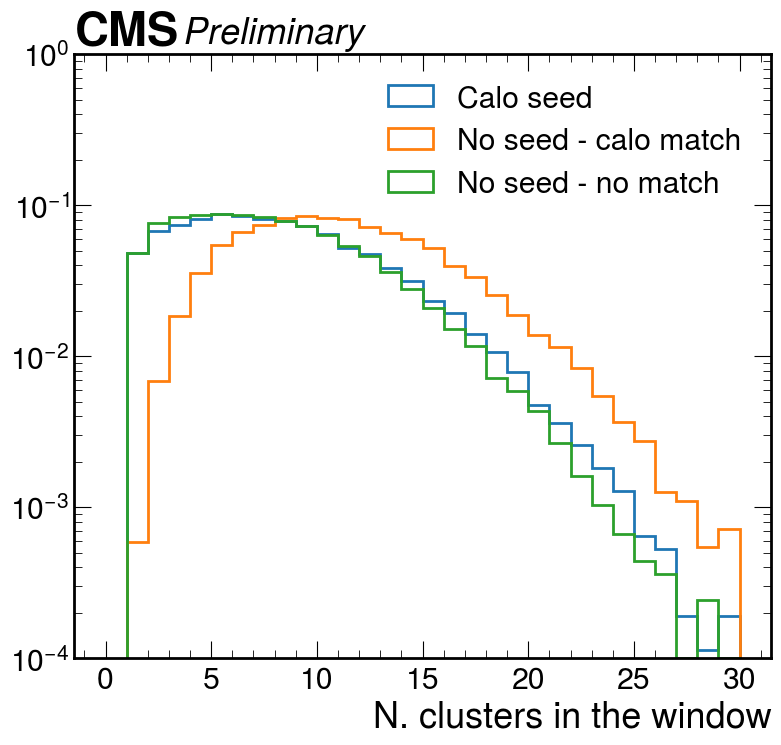

In [28]:
bins = 30
xrange = [0,30]
var = 'n_cl'
title = 'N. clusters in the window'
log = True
ylim = [1e-4, 1]

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend()
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

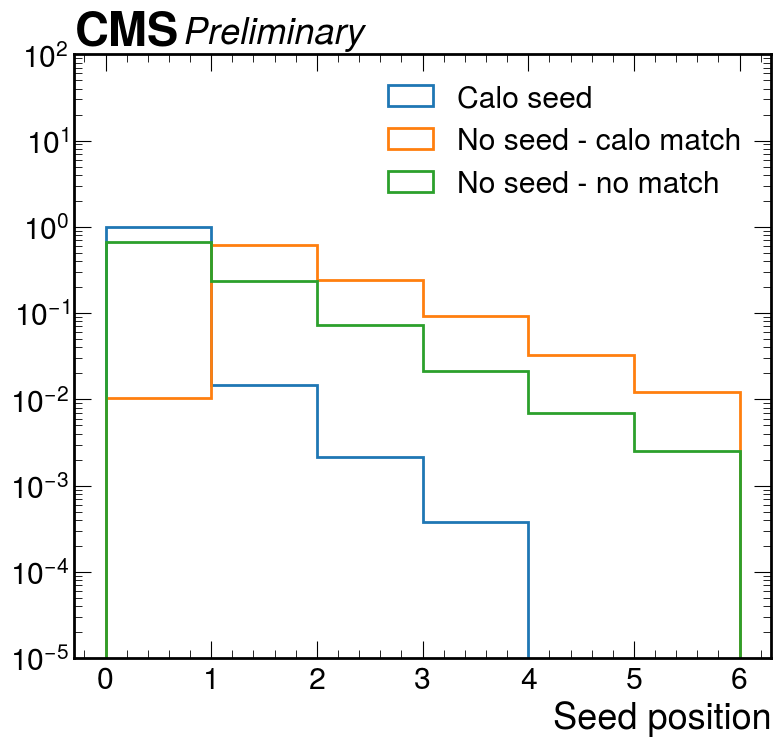

In [29]:
bins = 6
xrange = [0,6]
var = 'seed_pos'
title = 'Seed position'
log = True
ylim = [1e-5, 1e2]

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend()
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

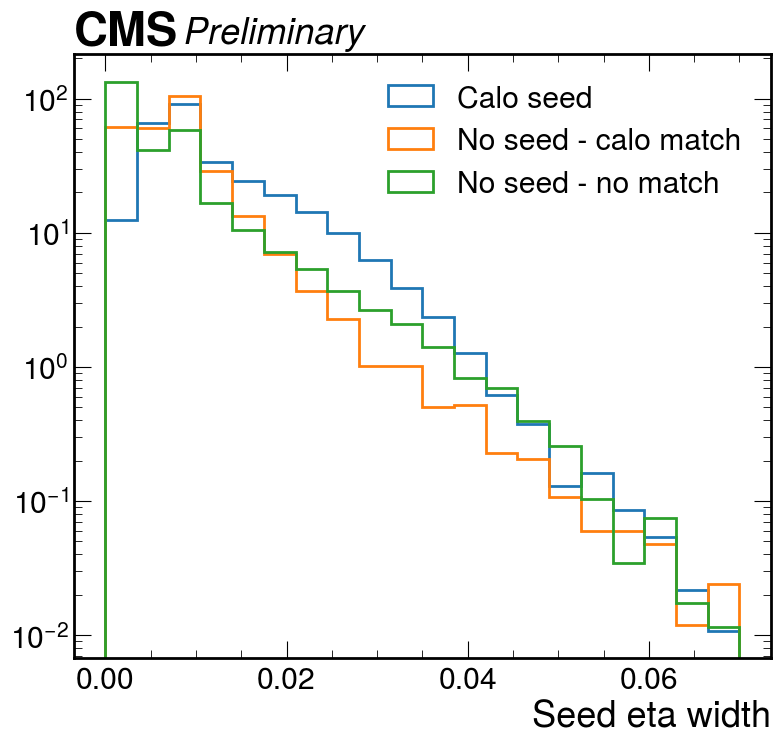

In [31]:
bins = 20
xrange = [0,0.07]
var = 'seed_etaWidth'
title = 'Seed eta width'
log = True
ylim = []

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend()
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

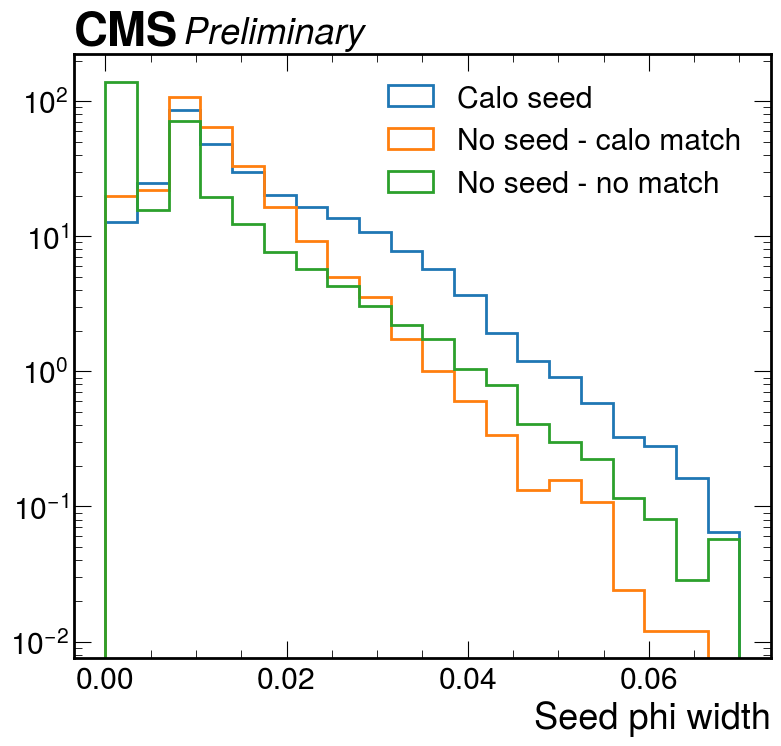

In [32]:
bins = 20
xrange = [0,0.07]
var = 'seed_phiWidth'
title = 'Seed phi width'
log = True
ylim = []

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend()
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

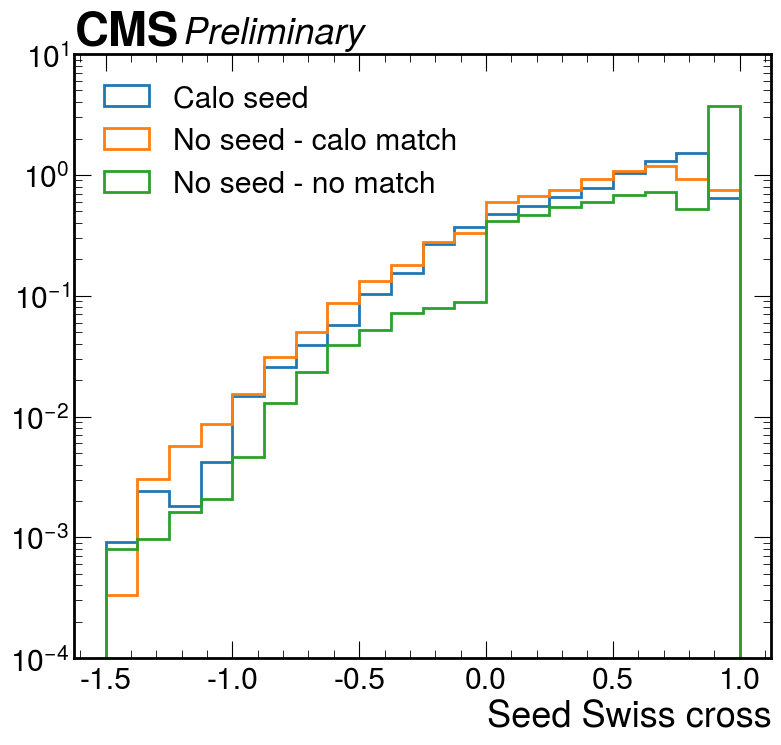

In [35]:
bins = 20
xrange = [-1.5,1]
var = 'seed_swissCross'
title = 'Seed Swiss cross'
log = True
ylim = [1e-4,10]

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend(loc="upper left")
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

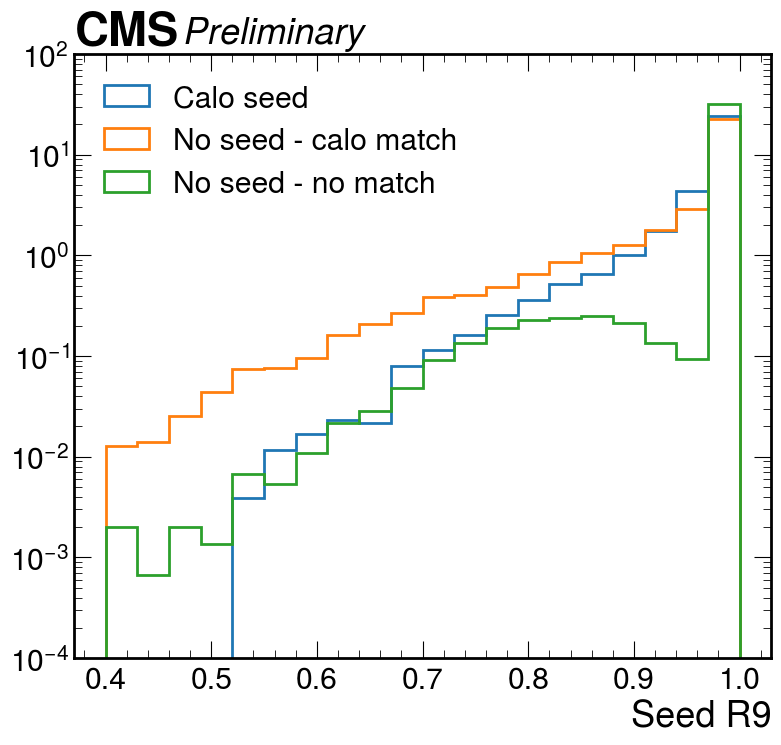

In [36]:
bins = 20
xrange = [0.4,1]
var = 'seed_r9'
title = 'Seed R9'
log = True
ylim = [1e-4, 1e2]

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend(loc="upper left")
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

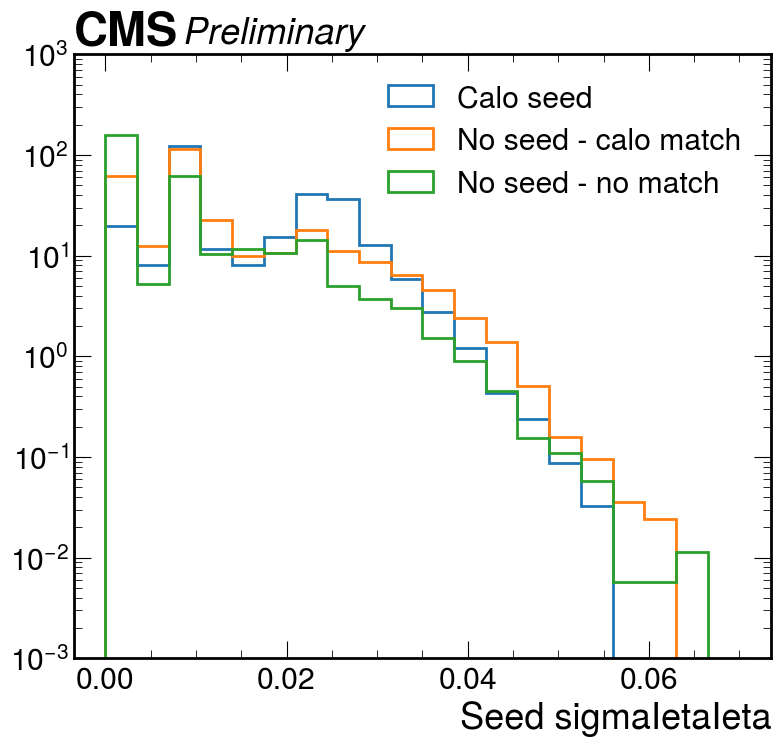

In [37]:
bins = 20
xrange = [0,0.07]
var = 'seed_sigmaIetaIeta'
title = 'Seed sigmaIetaIeta'
log = True
ylim = [1e-3, 1e3]

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend(loc="upper right")
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

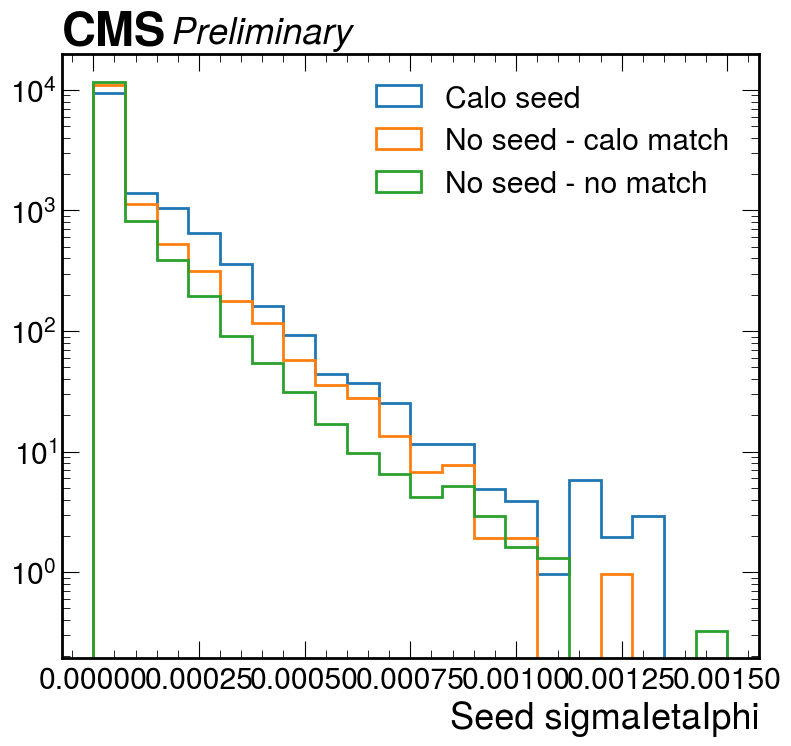

In [39]:
bins = 20
xrange = [0,0.0015]
var = 'seed_sigmaIetaIphi'
title = 'Seed sigmaIetaIphi'
log = True
ylim = []

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend(loc="upper right")
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

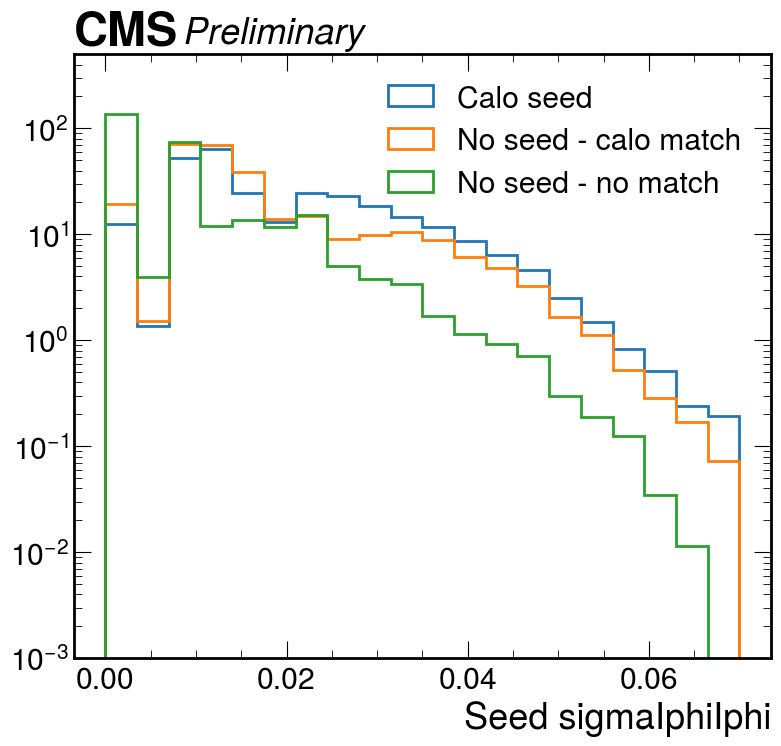

In [40]:
bins = 20
xrange = [0,0.07]
var = 'seed_sigmaIphiIphi'
title = 'Seed sigmaIphiIphi'
log = True
ylim = [1e-3, 5e2]

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend(loc="upper right")
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary '))

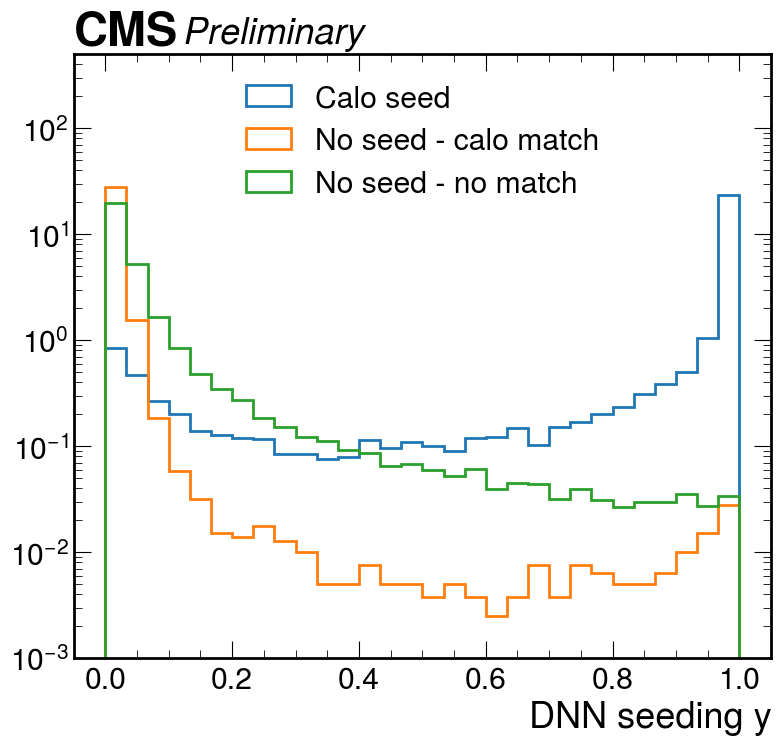

In [41]:
bins = 30
xrange = [0,1]
var = 'y'
title = 'DNN seeding y'
log = True
ylim = [1e-3, 5e2]

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend(loc="upper center")
hep.cms.text("Preliminary ",loc=0)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary '))

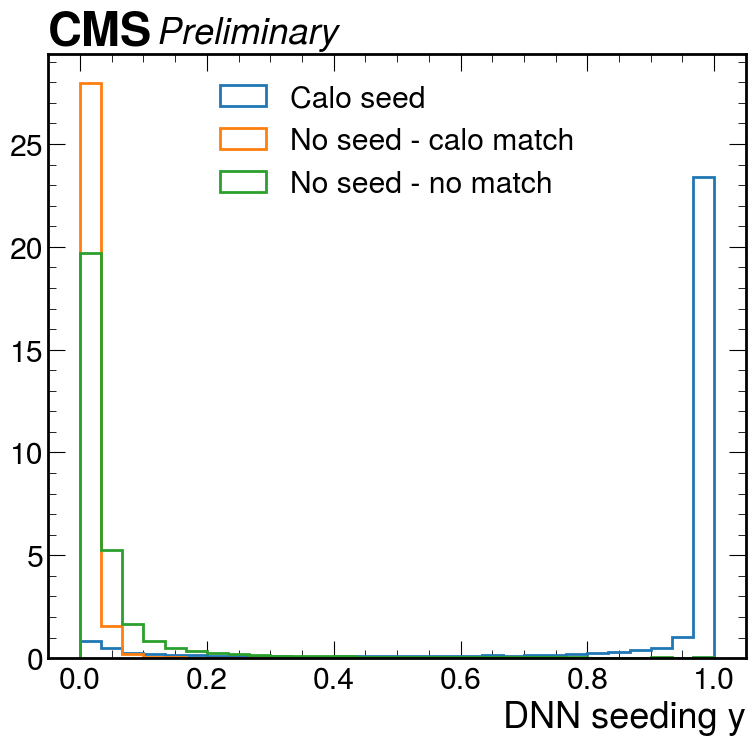

In [42]:
bins = 30
xrange = [0,1]
var = 'y'
title = 'DNN seeding y'
log = False
ylim = []

fig,  ax1 = plt.subplots(1,1, figsize=(9,8), dpi=100)
plt.hist(df[df.y_true==1][var], bins=bins, range=xrange,  histtype='step',density=True, label="Calo seed", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==1)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - calo match", linewidth=2)
plt.hist(df[(df.y_true==0) & (df.calo_match ==0)][var], bins=bins, range=xrange,  histtype='step',density=True, label="No seed - no match", linewidth=2)
plt.xlabel(title)
if log: plt.yscale("log")
if ylim: plt.ylim(ylim)
plt.legend(loc="upper center")
hep.cms.text("Preliminary ",loc=0)

In [31]:
from sklearn.metrics import roc_curve,roc_auc_score

In [33]:
AUC = roc_auc_score(df.y_true, df.y)
print(AUC)

0.9806672858434006


(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary '))

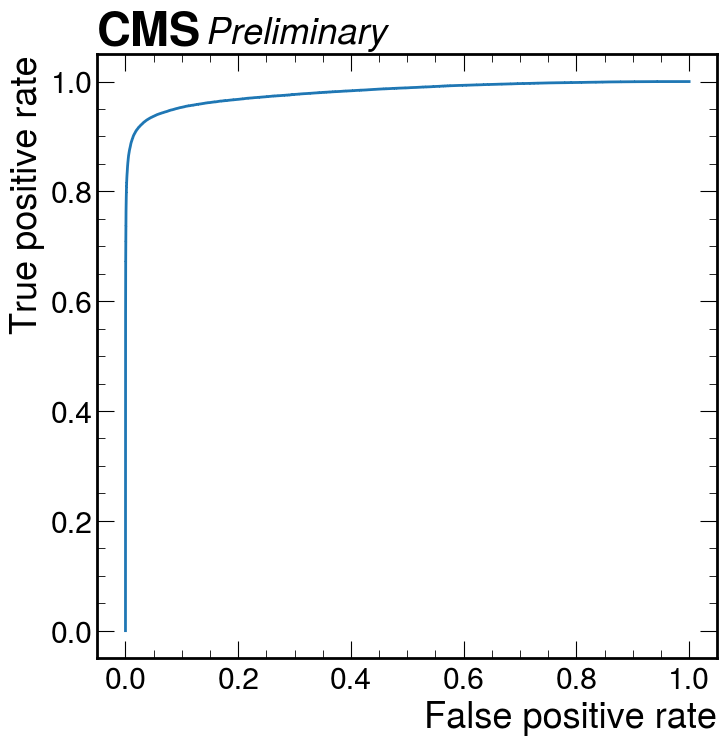

In [30]:
fpr, tpr,thr = roc_curve(df.y_true, df.y)
fig,  ax = plt.subplots(1,1, figsize=(8,8), dpi=100)
ax.plot(fpr,tpr,linewidth=2)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
hep.cms.text("Preliminary ",loc=0)

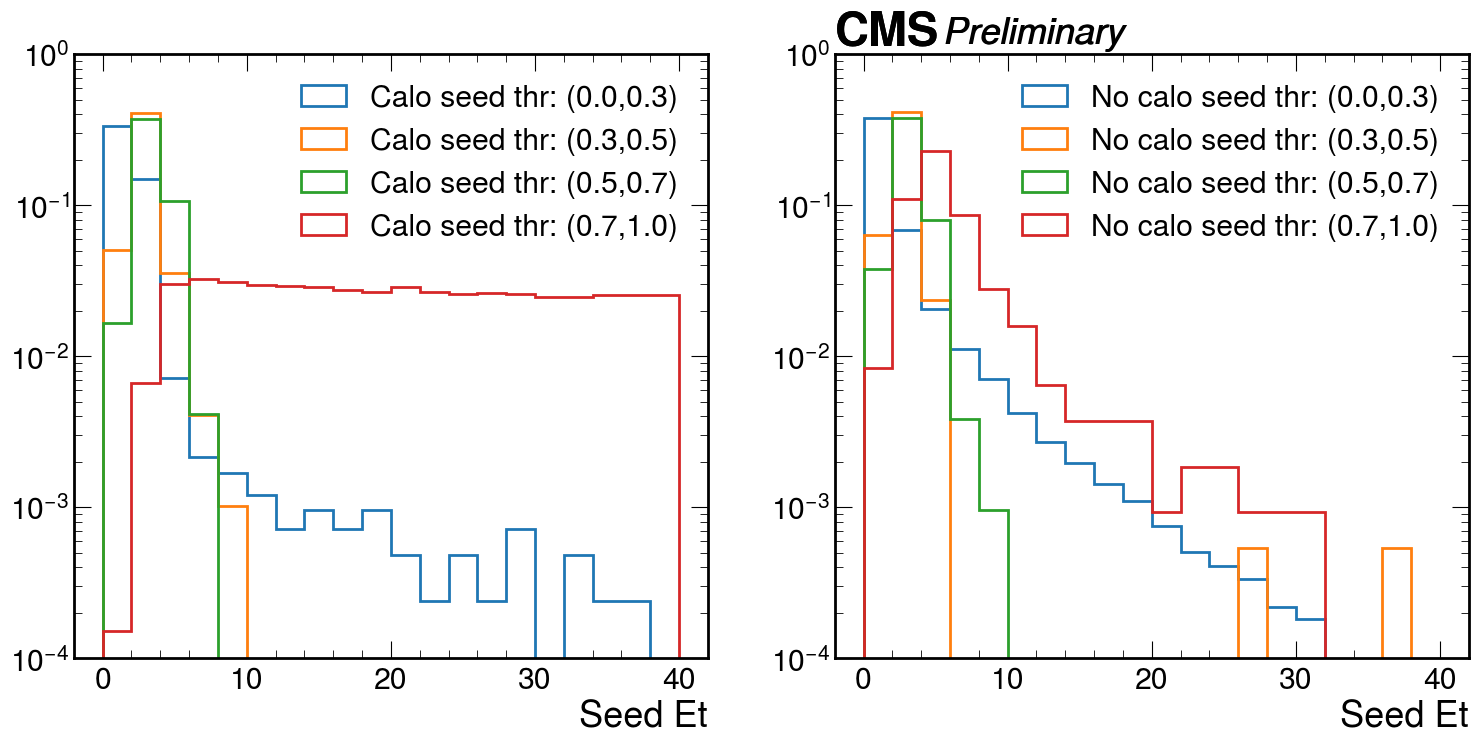

In [43]:
bins = 20
xrange = [0,40]
var = 'et_seed'
title = 'Seed Et'
log = True
ylim = [1e-4, 1]
ybins = [0,0.3,0.5,0.7,1]

fig,  axs = plt.subplots(1,2, figsize=(18,8), dpi=100)
for yt,ax in zip([1,0],axs):
    for yb in range(len(ybins)-1):
        ax.hist(df[(df.y_true==yt) & (df.y > ybins[yb]) & (df.y< ybins[yb+1])][var], bins=bins, range=xrange,  histtype='step',
                density=True, label="{} seed thr: ({:.1f},{:.1f})".format("Calo" if yt==1 else "No calo", ybins[yb],ybins[yb+1]),
                linewidth=2)
    

    ax.set_xlabel(title)
    if log: ax.set_yscale("log")
    if ylim: ax.set_ylim(ylim)
    ax.legend(loc="upper right")
    hep.cms.text("Preliminary ",loc=0)

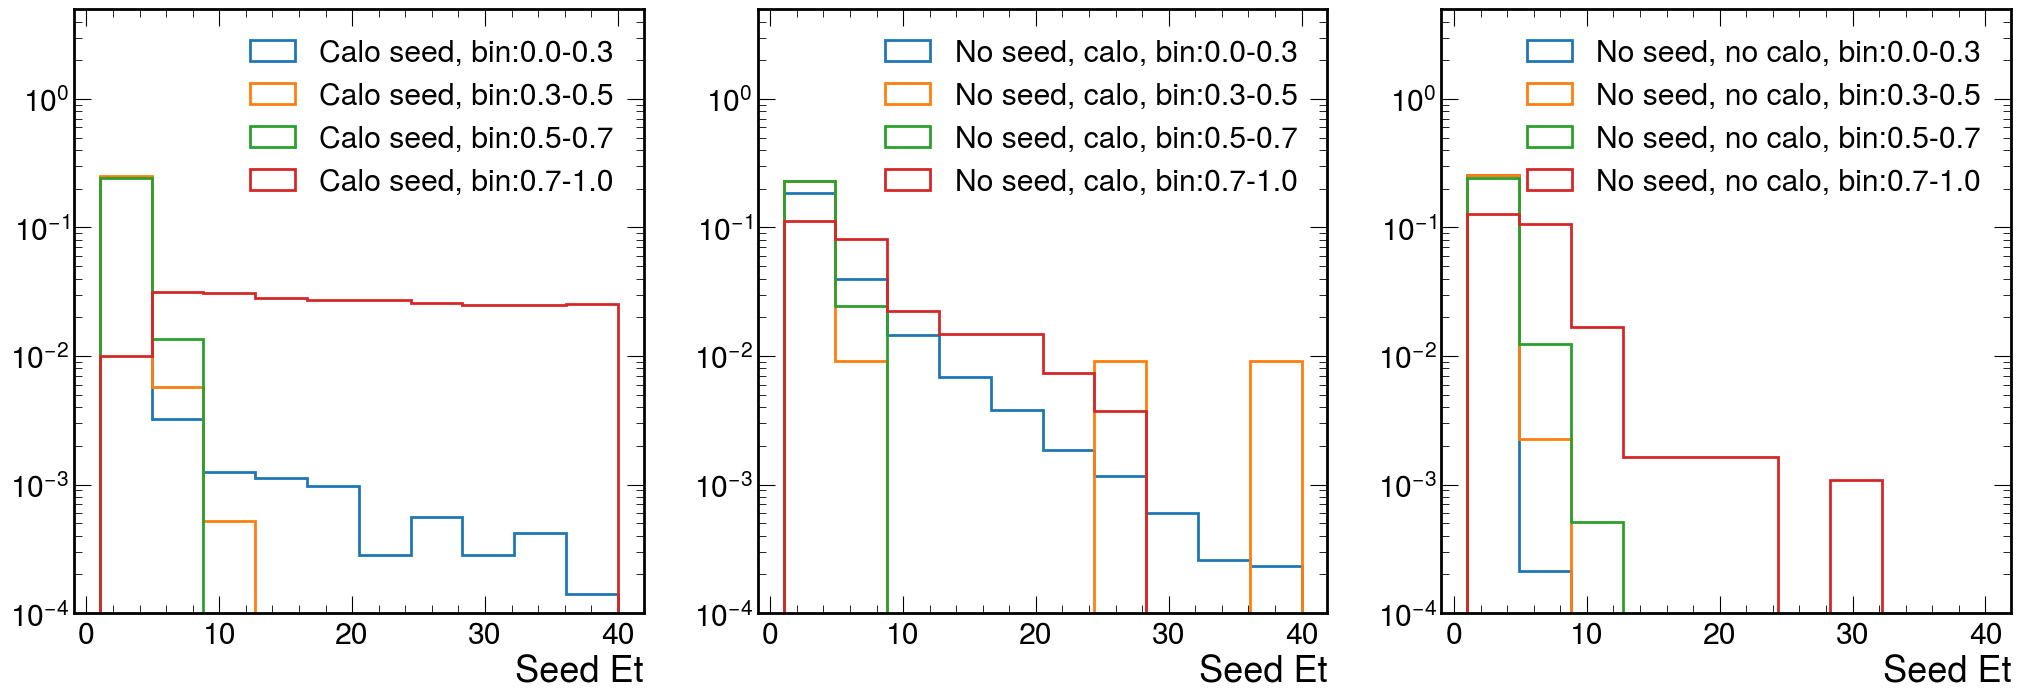

In [44]:
bins = 10
xrange = [1,40]
var = 'et_seed'
title = 'Seed Et'
log = True
ylim = [1e-4, 5]
ybins = [0,0.3,0.5,0.7,1]
cmslabel =False

fig,  axs = plt.subplots(1,3, figsize=(25,8), dpi=100)
for yt,cm, ax in zip([1,0,0],[1,1,0], axs):
    for yb in range(len(ybins)-1):
        label = ""
        if yt==1: label= "Calo seed"
        if yt==0:
            if cm ==0: label= "No seed, no calo"
            if cm ==1: label= "No seed, calo"
        ax.hist(df[(df.y_true==yt) & (df.calo_match==cm) & (df.y > ybins[yb]) & (df.y< ybins[yb+1])][var], bins=bins, range=xrange,  histtype='step',
                density=True, label="{}, bin:{:.1f}-{:.1f}".format(label,  ybins[yb],ybins[yb+1]),
                linewidth=2)
    

    ax.set_xlabel(title)
    if log: ax.set_yscale("log")
    if ylim: ax.set_ylim(ylim)
    ax.legend(loc="upper right")
    

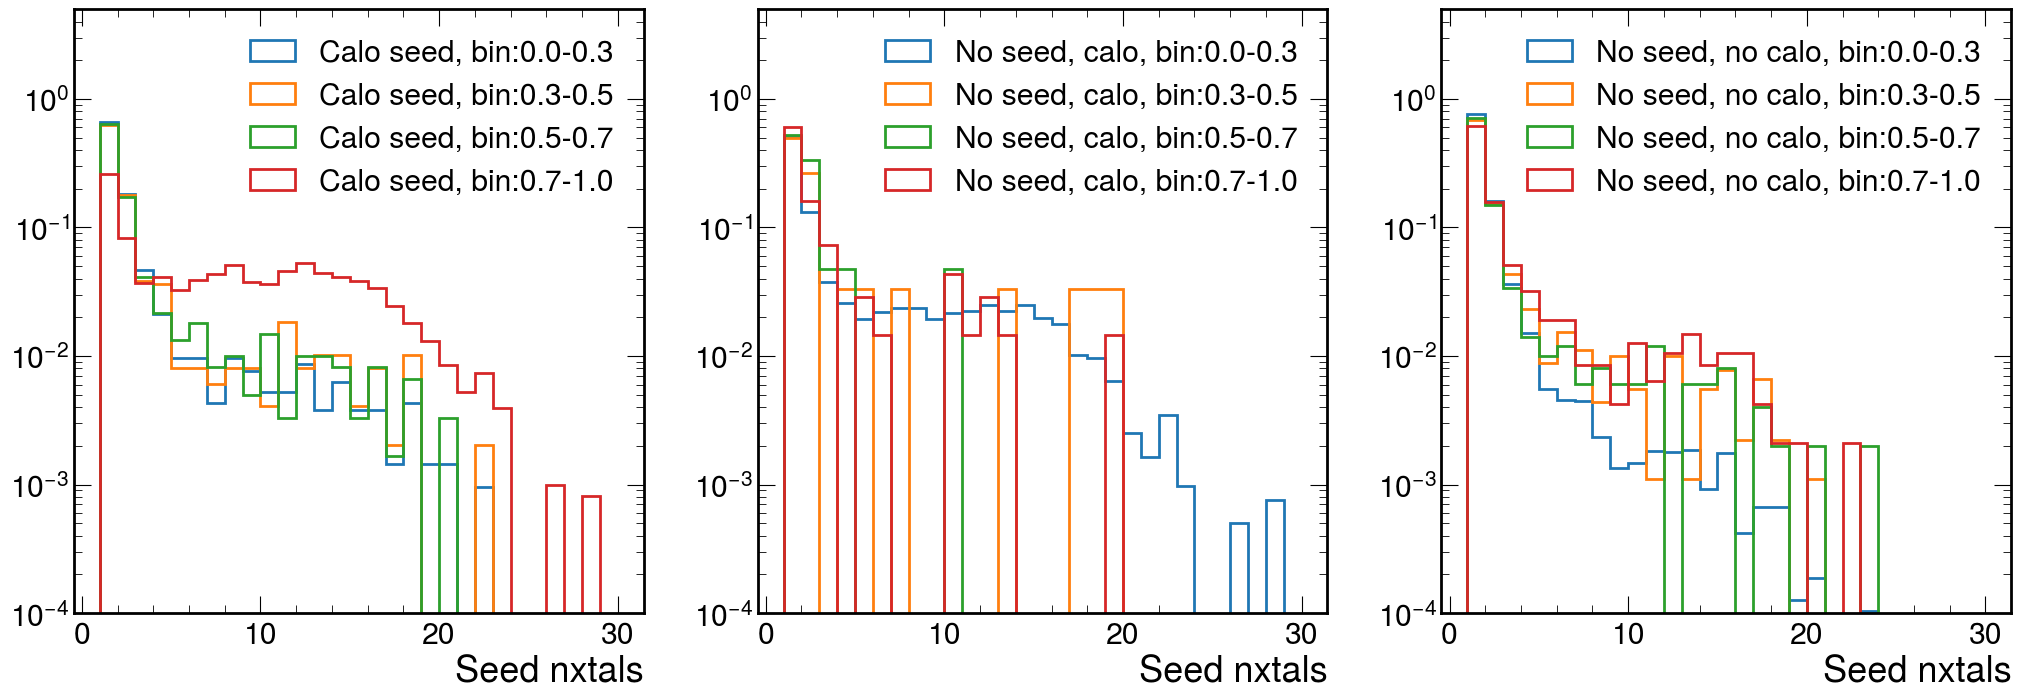

In [45]:
bins = 29
xrange = [1,30]
var = 'seed_nxtals'
title = 'Seed nxtals'
log = True
ylim = [1e-4, 5]
ybins = [0,0.3,0.5,0.7,1]
cmslabel =False

fig,  axs = plt.subplots(1,3, figsize=(25,8), dpi=100)
for yt,cm, ax in zip([1,0,0],[1,1,0], axs):
    for yb in range(len(ybins)-1):
        label = ""
        if yt==1: label= "Calo seed"
        if yt==0:
            if cm ==0: label= "No seed, no calo"
            if cm ==1: label= "No seed, calo"
        ax.hist(df[(df.y_true==yt) & (df.calo_match==cm) & (df.y > ybins[yb]) & (df.y< ybins[yb+1])][var], bins=bins, range=xrange,  histtype='step',
                density=True, label="{}, bin:{:.1f}-{:.1f}".format(label,  ybins[yb],ybins[yb+1]),
                linewidth=2)
    

    ax.set_xlabel(title)
    if log: ax.set_yscale("log")
    if ylim: ax.set_ylim(ylim)
    ax.legend(loc="upper right")
    

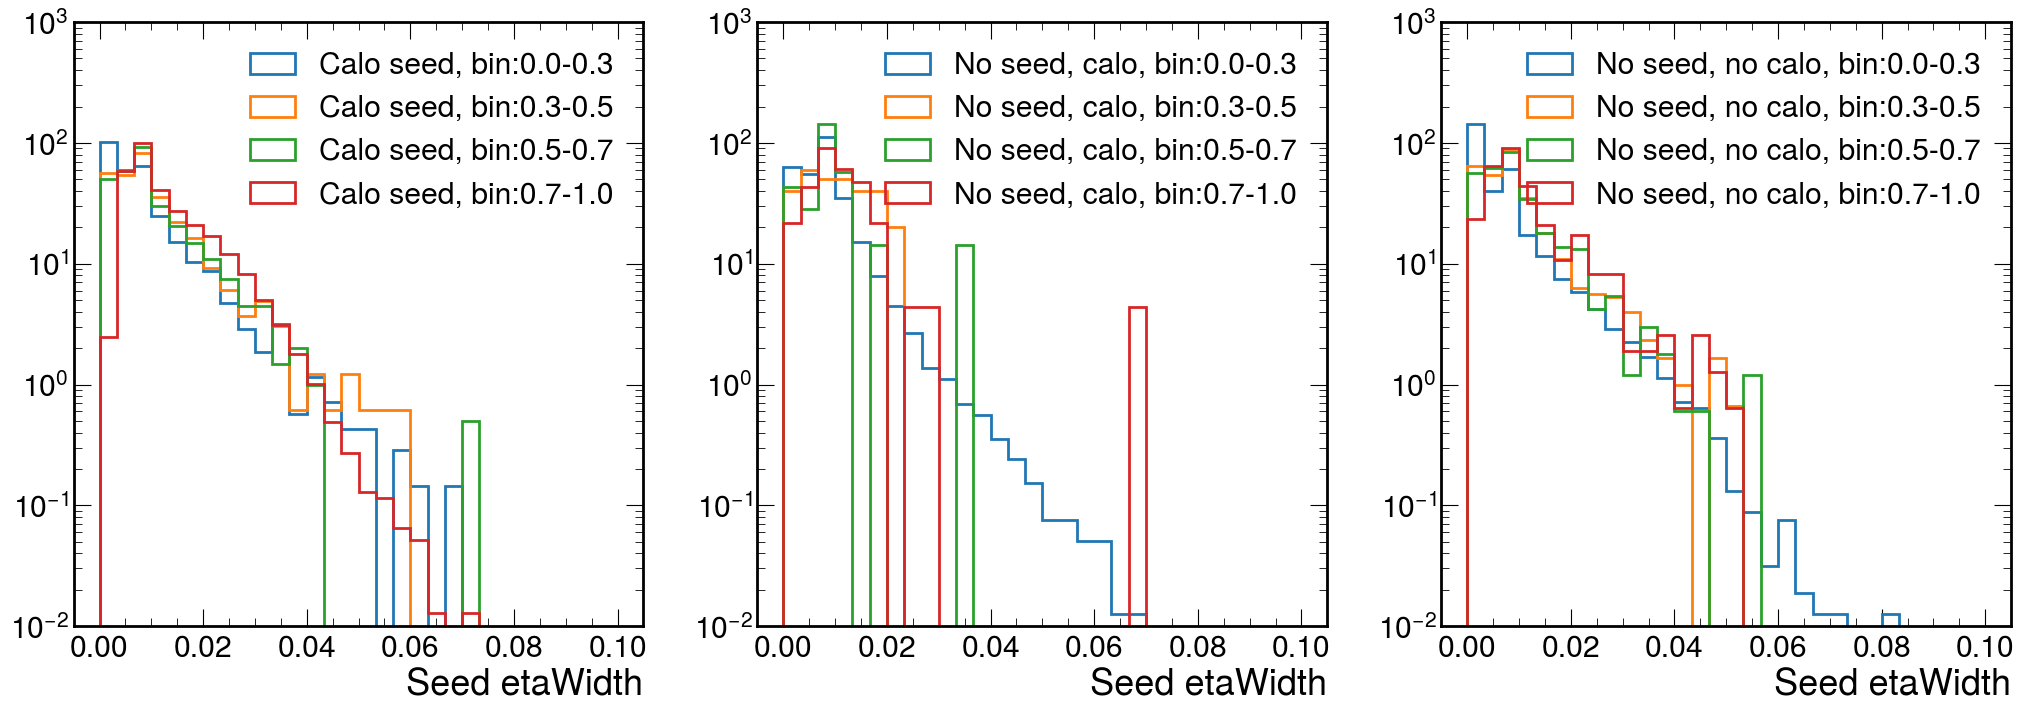

In [46]:
bins = 30
xrange = [0,0.1]
var = 'seed_etaWidth'
title = 'Seed etaWidth'
log = True
ylim = [1e-2, 1e3]
ybins = [0,0.3,0.5,0.7,1]
cmslabel =False

fig,  axs = plt.subplots(1,3, figsize=(25,8), dpi=100)
for yt,cm, ax in zip([1,0,0],[1,1,0], axs):
    for yb in range(len(ybins)-1):
        label = ""
        if yt==1: label= "Calo seed"
        if yt==0:
            if cm ==0: label= "No seed, no calo"
            if cm ==1: label= "No seed, calo"
        ax.hist(df[(df.y_true==yt) & (df.calo_match==cm) & (df.y > ybins[yb]) & (df.y< ybins[yb+1])][var], bins=bins, range=xrange,  histtype='step',
                density=True, label="{}, bin:{:.1f}-{:.1f}".format(label,  ybins[yb],ybins[yb+1]),
                linewidth=2)
    

    ax.set_xlabel(title)
    if log: ax.set_yscale("log")
    if ylim: ax.set_ylim(ylim)
    ax.legend(loc="upper right")
    

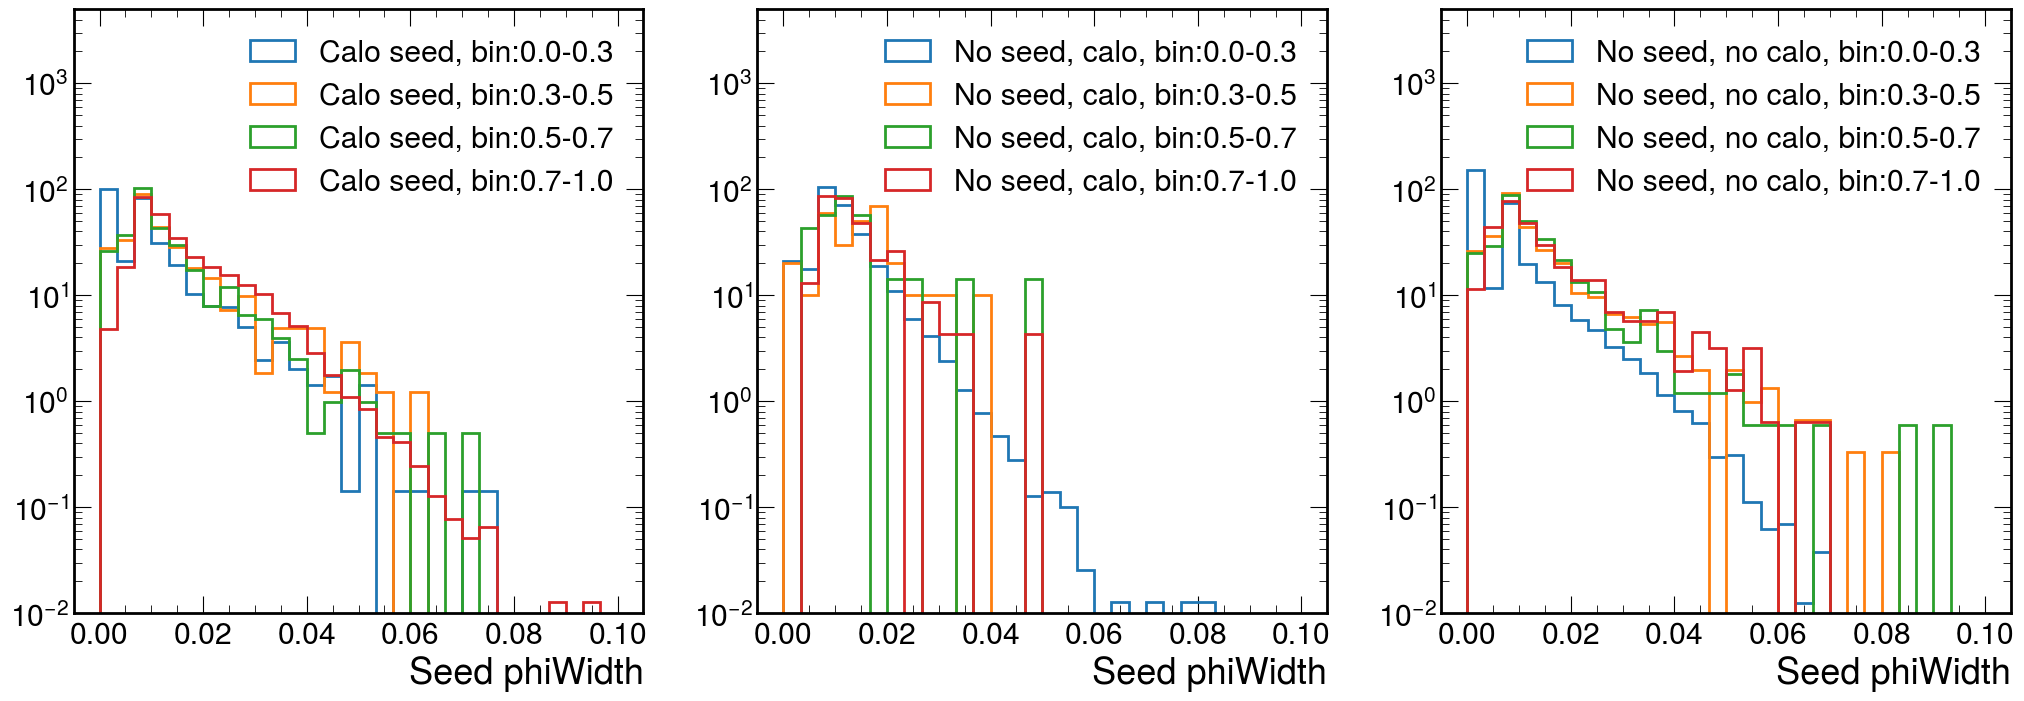

In [47]:
bins = 30
xrange = [0,0.1]
var = 'seed_phiWidth'
title = 'Seed phiWidth'
log = True
ylim = [1e-2, 5e3]
ybins = [0,0.3,0.5,0.7,1]
cmslabel =False

fig,  axs = plt.subplots(1,3, figsize=(25,8), dpi=100)
for yt,cm, ax in zip([1,0,0],[1,1,0], axs):
    for yb in range(len(ybins)-1):
        label = ""
        if yt==1: label= "Calo seed"
        if yt==0:
            if cm ==0: label= "No seed, no calo"
            if cm ==1: label= "No seed, calo"
        ax.hist(df[(df.y_true==yt) & (df.calo_match==cm) & (df.y > ybins[yb]) & (df.y< ybins[yb+1])][var], bins=bins, range=xrange,  histtype='step',
                density=True, label="{}, bin:{:.1f}-{:.1f}".format(label,  ybins[yb],ybins[yb+1]),
                linewidth=2)
    

    ax.set_xlabel(title)
    if log: ax.set_yscale("log")
    if ylim: ax.set_ylim(ylim)
    ax.legend(loc="upper right")
    

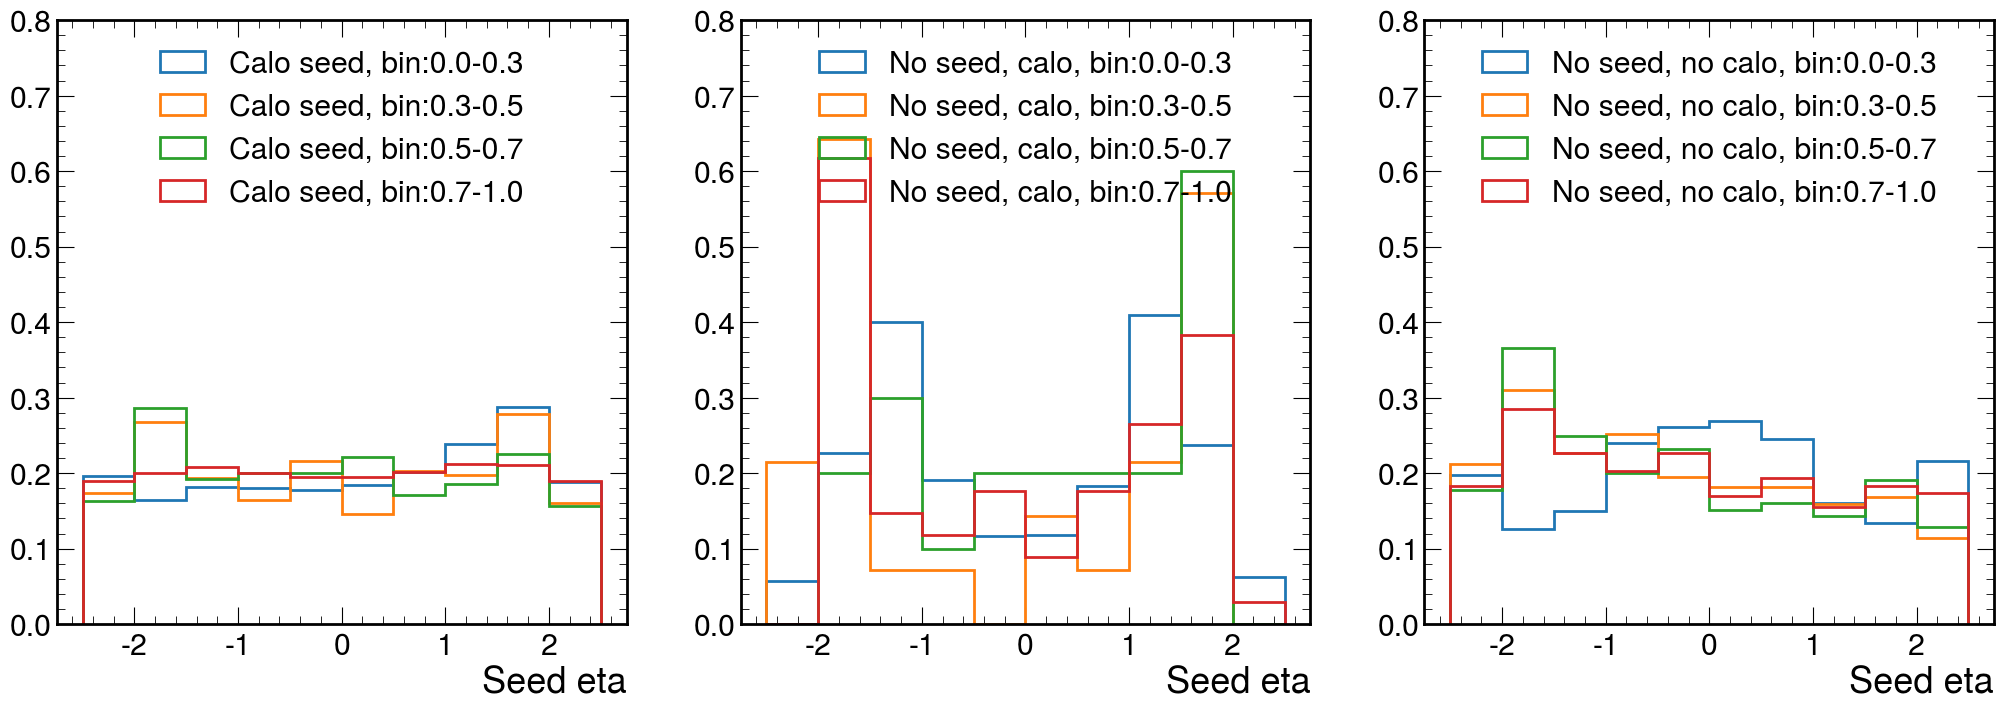

In [48]:
bins = 10
xrange=[-2.5,2.5 ]
var = 'seed_eta'
title = 'Seed eta'
log = False
ylim = [0,0.8]
ybins = [0,0.3,0.5,0.7,1]
cmslabel =False

fig,  axs = plt.subplots(1,3, figsize=(25,8), dpi=100)
for yt,cm, ax in zip([1,0,0],[1,1,0], axs):
    for yb in range(len(ybins)-1):
        label = ""
        if yt==1: label= "Calo seed"
        if yt==0:
            if cm ==0: label= "No seed, no calo"
            if cm ==1: label= "No seed, calo"
        ax.hist(df[(df.y_true==yt) & (df.calo_match==cm) & (df.y > ybins[yb]) & (df.y< ybins[yb+1])][var], bins=bins, range=xrange,  histtype='step',
                density=True, label="{}, bin:{:.1f}-{:.1f}".format(label,  ybins[yb],ybins[yb+1]),
                linewidth=2)
    

    ax.set_xlabel(title)
    if log: ax.set_yscale("log")
    if ylim: ax.set_ylim(ylim)
    ax.legend(loc="upper center")
    

Text(1560.6495098039215, 1, 'Seed eta')

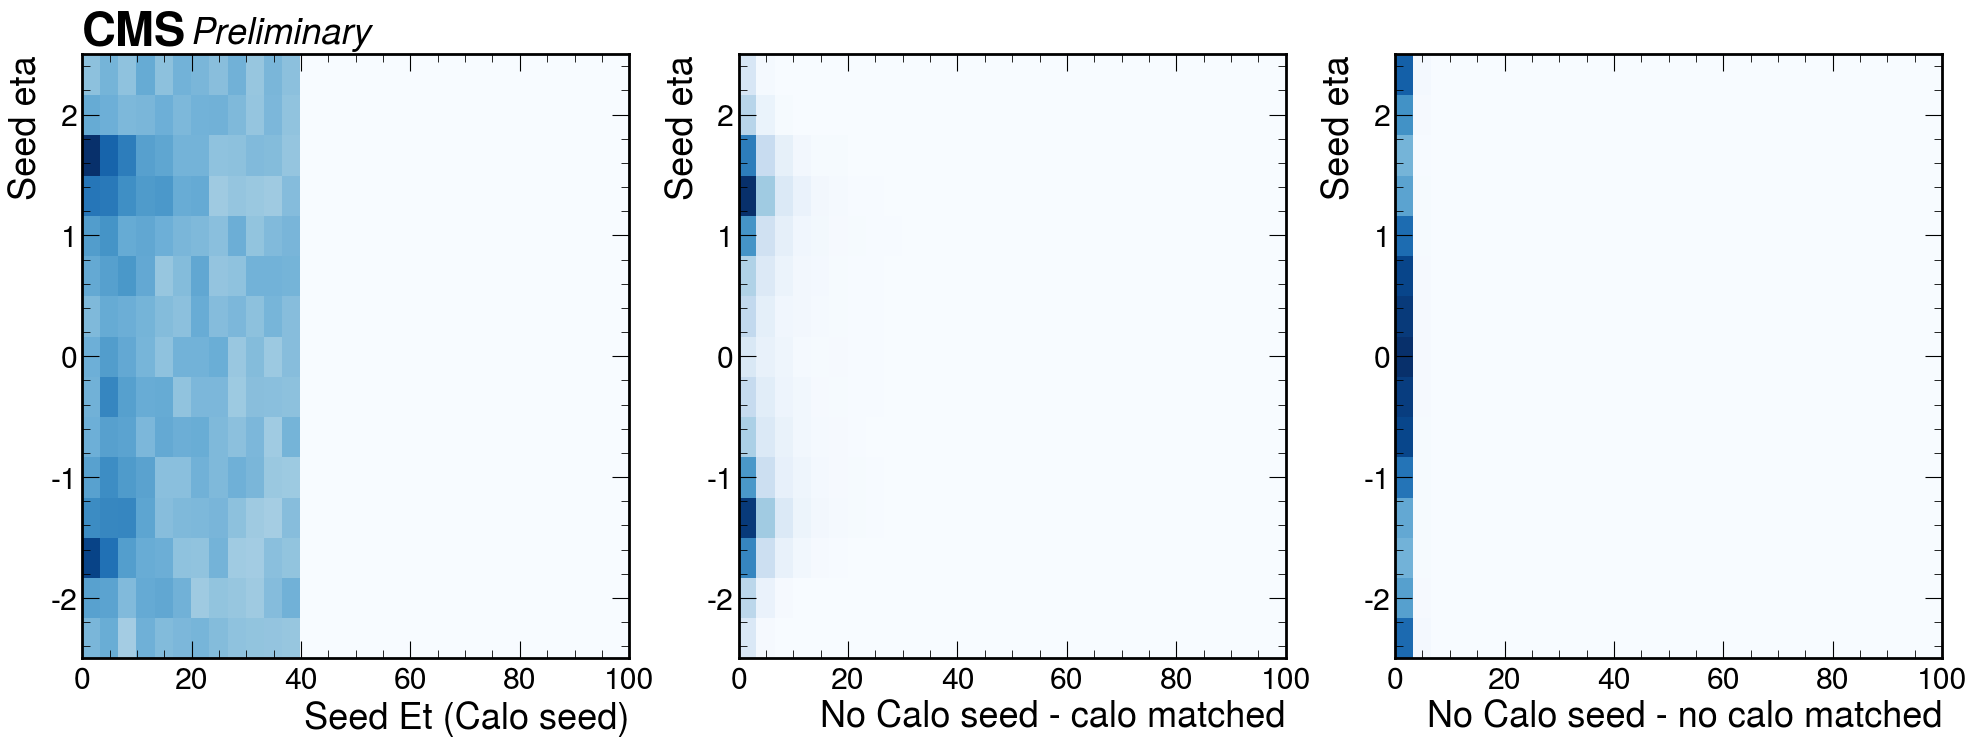

In [49]:
fig,  (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,8), dpi=100)
ax1.hist2d(df[(df.y_true==1) ]['et_seed'],df[(df.y_true==1)]['seed_eta'], range=[[0,100],[-2.5,2.5]], bins=[30,15], cmap="Blues")
ax1.set_xlabel("Seed Et (Calo seed)")
ax1.set_ylabel("Seed eta")
hep.cms.text("Preliminary", loc=0, ax=ax1)

ax2.hist2d(df[(df.y_true==0) & (df.calo_match) ]['et_seed'],df[(df.y_true==0) & (df.calo_match) ]['seed_eta'], range=[[0,100],[-2.5,2.5]], bins=[30,15], cmap="Blues")
ax2.set_xlabel("No Calo seed - calo matched")
ax2.set_ylabel("Seed eta")

ax3.hist2d(df[(df.y_true==0) & (df.calo_match==0) ]['et_seed'],df[(df.y_true==0) & (df.calo_match==0) ]['seed_eta'], range=[[0,100],[-2.5,2.5]], bins=[30,15], cmap="Blues")
ax3.set_xlabel("No Calo seed - no calo matched")
ax3.set_ylabel("Seed eta")

In [103]:
ets = [0,2,3,4, 5,7,10,12,14,15,20,25,30,35,40]
etas = [0, 0.5,1.0, 1.25,1.479, 1.75,2.,2.5,3]
ncls = [0,2,3,5,10,15,20,25,30,35,50]

df["eta_bin"] = pd.cut(abs(df.seed_eta), etas, labels=list(range(len(etas)-1)))
df["et_bin"] = pd.cut(df.et_seed, ets, labels=list(range(len(ets)-1)))
df["ncls_bin"] = pd.cut(df.n_cl, ncls, labels=list(range(len(ncls)-1)))

In [104]:
def true_pos(thr):
    def f(g):
        p = g.y_true.sum()
        tp = g[g.y > thr].y_true.sum() / p
        return tp
    return f

def false_pos(thr):
    def f(g):
        n = (1-g.y_true).sum()
        fp = (1- g[g.y > thr].y_true).sum() / n
        return fp
    return f

In [105]:
etbindf = df.groupby(["et_bin"])

In [106]:
recall = {}
fp = {}
precision = {}
tn = {}

for thr in [0.1,0.2,0.3,0.5,0.65,0.8]:
    recall[thr] =  etbindf.apply(true_pos(thr))
    fp[thr] = etbindf.apply(false_pos(thr))
    tn[thr] = 1- etbindf.apply(false_pos(thr))
    precision[thr] = recall[thr] / (recall[thr] + fp[thr])
    

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

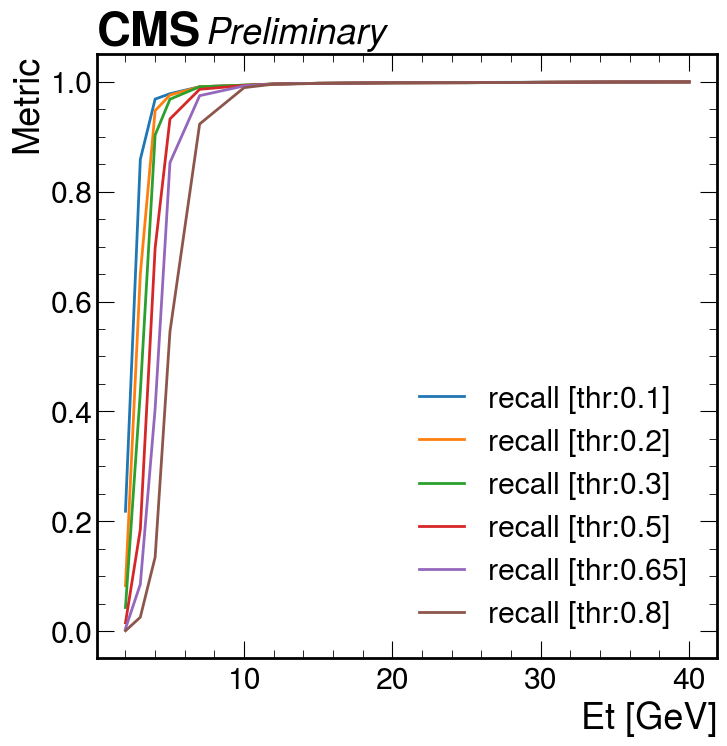

In [82]:
fig,  ax = plt.subplots(1,1, figsize=(8,8), dpi=100)
for thr in [0.1,0.2,0.3,0.5,0.65,0.8]:
    ax.plot(ets[1:], recall[thr],linewidth=2, label="recall [thr:{}]".format(thr))
    
ax.set_xlabel("Et [GeV]")
ax.set_ylabel("Metric")
ax.legend()

hep.cms.text("Preliminary", loc=0)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

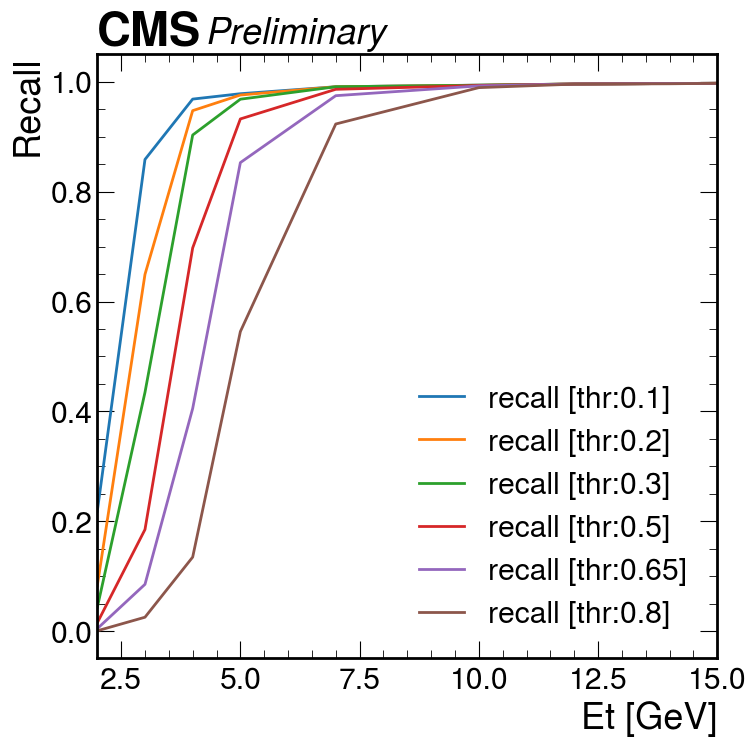

In [85]:
fig,  ax = plt.subplots(1,1, figsize=(8,8), dpi=100)
for thr in [0.1, 0.2,0.3,0.5,0.65,0.8]:
    ax.plot(ets[1:], recall[thr],linewidth=2, label="recall [thr:{}]".format(thr))
    
ax.set_xlim(2,15)    
ax.set_xlabel("Et [GeV]")
ax.set_ylabel("Recall")
ax.legend()

hep.cms.text("Preliminary", loc=0)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

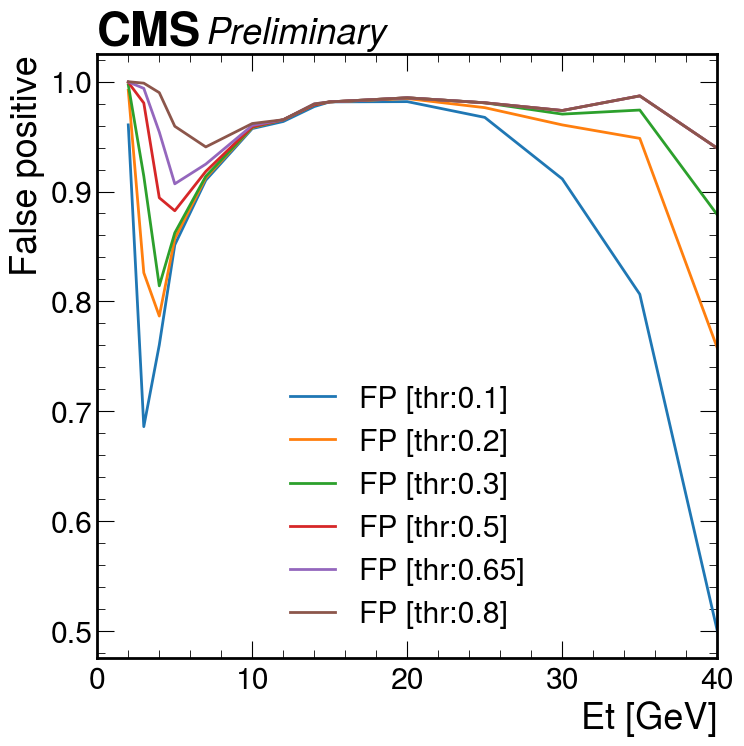

In [107]:
fig,  ax = plt.subplots(1,1, figsize=(8,8), dpi=100)
for thr in [0.1, 0.2,0.3,0.5,0.65,0.8]:
    ax.plot(ets[1:], fp[thr],linewidth=2, label="FP [thr:{}]".format(thr))
    
ax.set_xlim(0,40)    
ax.set_xlabel("Et [GeV]")
ax.set_ylabel("False positive")
ax.legend()

hep.cms.text("Preliminary", loc=0)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

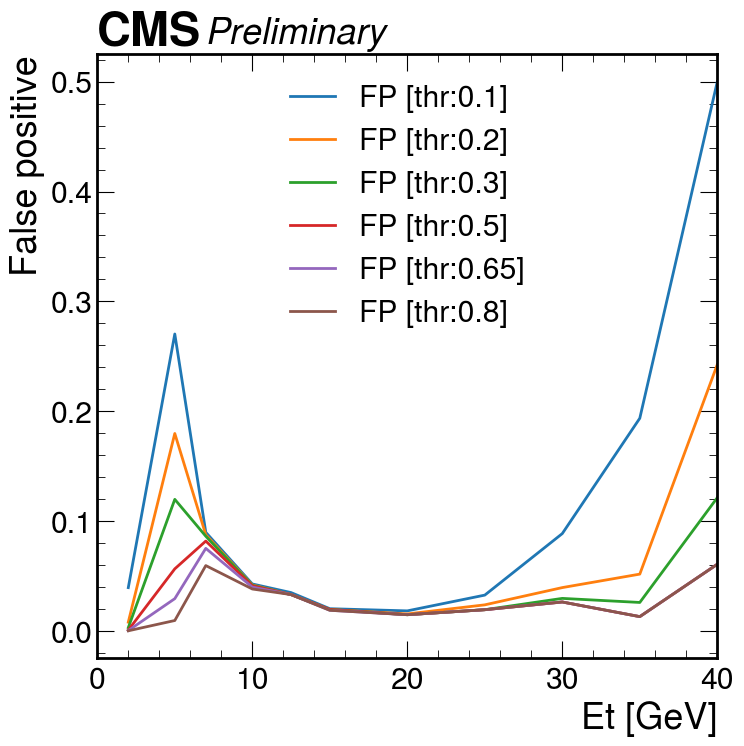

In [74]:
fig,  ax = plt.subplots(1,1, figsize=(8,8), dpi=100)
for thr in [0.1, 0.2,0.3,0.5,0.65,0.8]:
    ax.plot(ets[1:], fp[thr],linewidth=2, label="FP [thr:{}]".format(thr))
    
ax.set_xlim(0,40)    
ax.set_xlabel("Et [GeV]")
ax.set_ylabel("False positive")
ax.legend()

hep.cms.text("Preliminary", loc=0)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

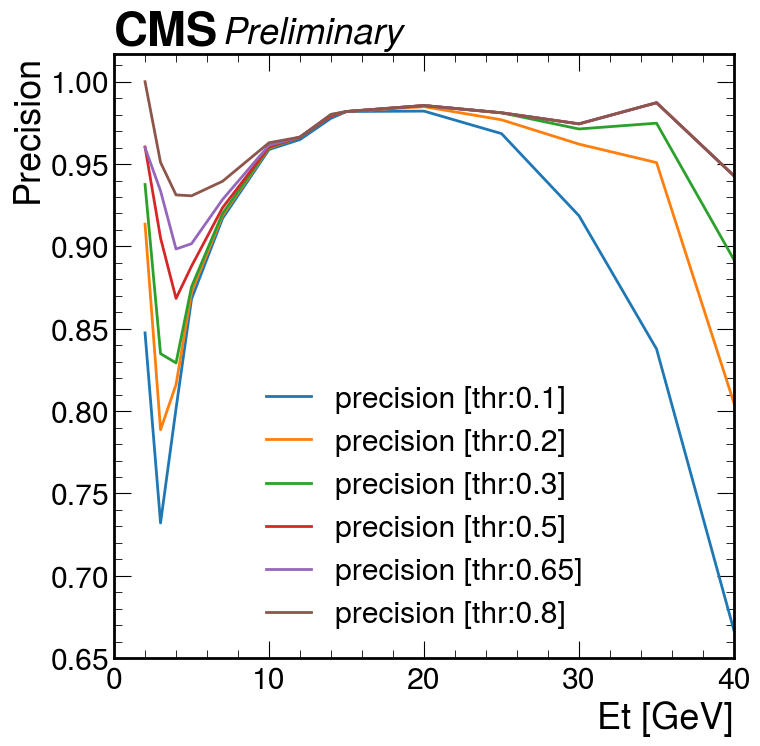

In [84]:
fig,  ax = plt.subplots(1,1, figsize=(8,8), dpi=100)
for thr in [0.1, 0.2,0.3,0.5,0.65,0.8]:
    ax.plot(ets[1:], precision[thr],linewidth=2, label="precision [thr:{}]".format(thr))
    
ax.set_xlim(0,40)    
ax.set_xlabel("Et [GeV]")
ax.set_ylabel("Precision")
ax.legend()

hep.cms.text("Preliminary", loc=0)

In [ ]:


def plot_eteta2D(data, title, zlabel="",**kwargs):

    a = data.values.reshape((len(etas)-1,len(ets)-1))

    plt.figure(figsize=(10,5))
    plt.imshow(a.T,**kwargs)
    plt.xlabel("Seed $\eta$")
    plt.ylabel("Seed $E_T$")
    plt.title(title)
    plt.colorbar(label=zlabel)

    plt.yticks(np.arange(len(ets)-1), ets)
    plt.xticks(np.arange(len(etas)-1), etas)

    locs, labels= plt.xticks()
    labels.append(etas[-1])
    locs = np.append(locs, [len(etas)-1])
    plt.xticks(locs-0.5, labels)

    locs, labels= plt.yticks()
    labels.append(ets[-1])
    locs = np.append(locs, [len(ets)-1])
    plt.yticks(locs-0.5, labels)

def plot_nclseta2D(data, title, zlabel="", **kwargs):

    a = data.values.reshape((len(etas)-1,len(ncls)-1))

    plt.figure(figsize=(10,5))
    plt.imshow(a.T, **kwargs)
    plt.xlabel("Seed $\eta$")
    plt.ylabel("N. clusters")
    plt.title(title)
    plt.colorbar(label=zlabel)

    plt.yticks(np.arange(len(ncls)-1), ncls)
    plt.xticks(np.arange(len(etas)-1), etas)

    locs, labels= plt.xticks()
    labels.append(etas[-1])
    locs = np.append(locs, [len(etas)-1])
    plt.xticks(locs-0.5, labels)

    locs, labels= plt.yticks()
    labels.append(ncls[-1])
    locs = np.append(locs, [len(ncls)-1])
    plt.yticks(locs-0.5, labels)

In [83]:
result

eta_bin  et_bin
0        0         0.386935
         1         0.985959
         2         0.994671
         3         0.994094
         4         0.994614
         5         0.991984
         6         0.995992
         7         0.997988
1        0         0.380805
         1         0.995223
         2         0.996485
         3         0.994253
         4         1.000000
         5         1.000000
         6         1.000000
         7         1.000000
2        0         0.417614
         1         0.994595
         2         0.996914
         3         1.000000
         4         1.000000
         5         1.000000
         6         1.000000
         7         1.000000
3        0         0.450633
         1         0.989501
         2         0.987013
         3         1.000000
         4         0.996364
         5         0.995671
                     ...   
4        2         1.000000
         3         0.989170
         4         1.000000
         5         1.000000
    

In [87]:
recall = {}
fp = {}
precision = {}

binsdf = df.groupby(["eta_bin", "et_bin"])

for thr in [0.1,0.2,0.3,0.5,0.65,0.8]:
    recall[thr] =  binsdf.apply(true_pos(thr)).unstack(fill_value=0).stack()
    fp[thr] = binsdf.apply(false_pos(thr)).unstack(fill_value=0).stack()
    precision[thr] = recall[thr] / (recall[thr] + fp[thr])
    

/usr/local/bin/start_ipykernel.py:11: RuntimeWarning: invalid value encountered in long_scalars


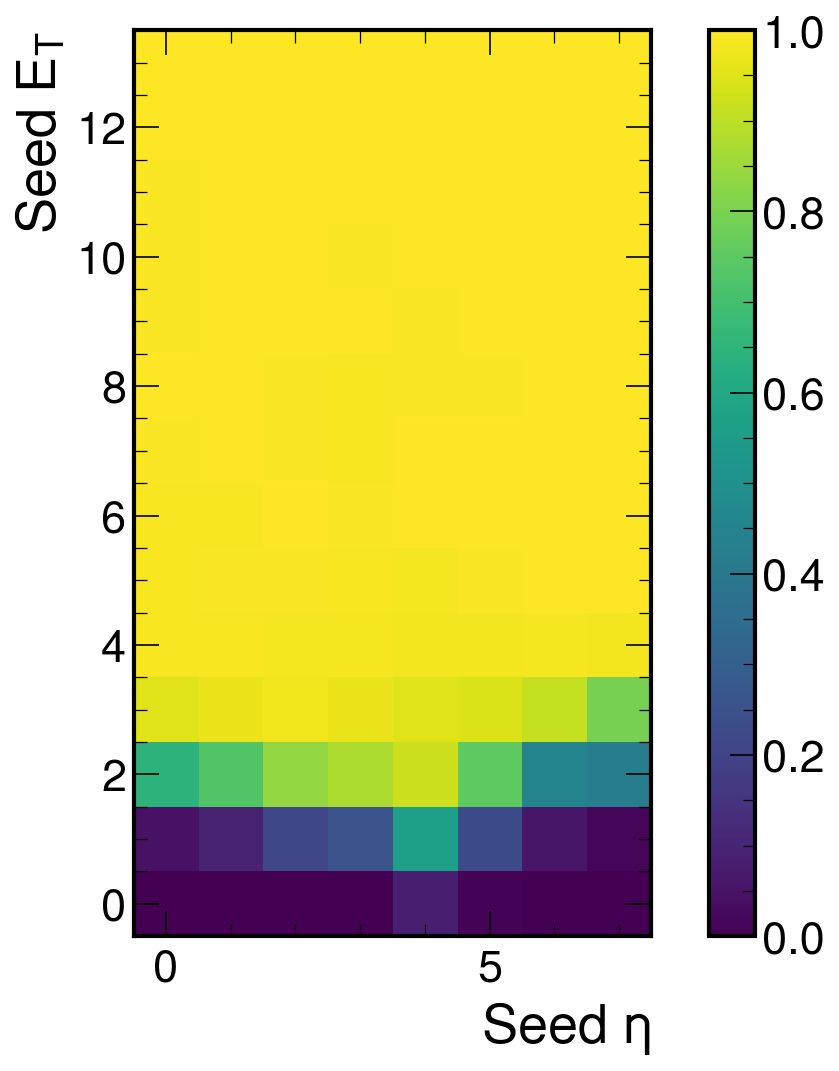

In [99]:
import matplotlib.colors as colors

a = recall[0.5].values.reshape((len(etas)-1,len(ets)-1))

plt.figure(figsize=(10,8))
plt.imshow(a.T)
plt.xlabel("Seed $\eta$")
plt.ylabel("Seed $E_T$")
plt.colorbar()


In [100]:
import matplotlib.colors as colors

a = fp[0.5].values.reshape((len(etas)-1,len(ets)-1))

plt.figure(figsize=(10,8))
plt.imshow(a.T)
plt.xlabel("Seed $\eta$")
plt.ylabel("Seed $E_T$")
plt.colorbar()


ValueError: cannot reshape array of size 106 into shape (8,14)

In [ ]:
plt.title(title)
plt.colorbar(label=zlabel)

plt.yticks(np.arange(len(ets)-1), ets)
plt.xticks(np.arange(len(etas)-1), etas)

locs, labels= plt.xticks()
labels.append(etas[-1])
locs = np.append(locs, [len(etas)-1])
plt.xticks(locs-0.5, labels)

locs, labels= plt.yticks()
labels.append(ets[-1])
locs = np.append(locs, [len(ets)-1])
plt.yticks(locs-0.5, labels)

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (9).

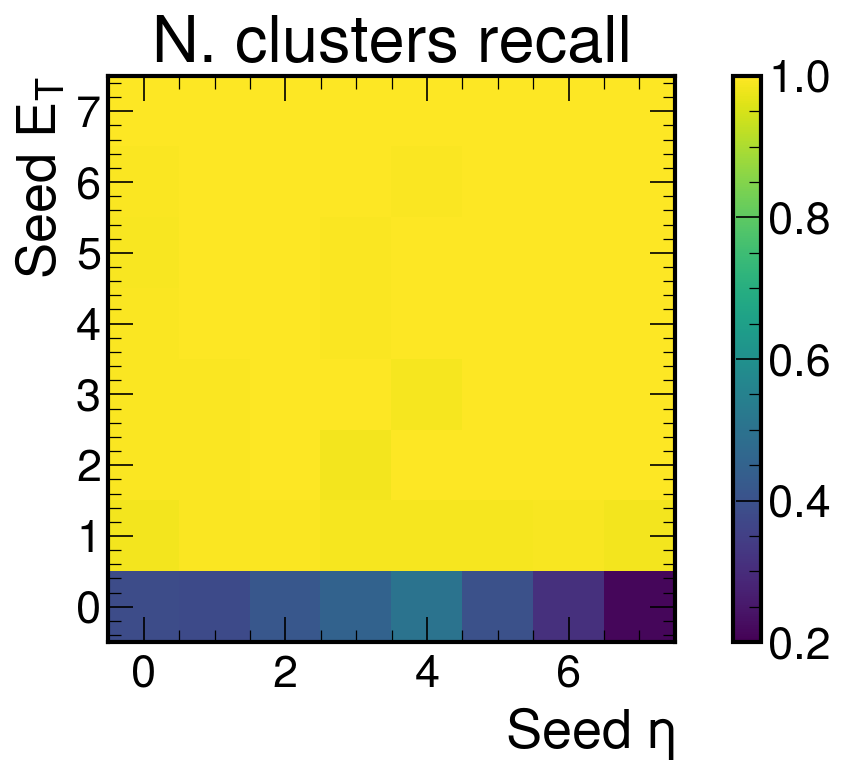

In [86]:
result =  df.groupby(["eta_bin", "et_bin"])\
             .apply(true_pos)\
             .unstack(fill_value=0).stack()

plot_eteta2D(result,"N. clusters recall", vmin=0.2, vmax=1)

In [29]:
p

352877